In [19]:
import pandas as pd

# Load the cleaned CSV
df_cleaned = pd.read_csv("cleaned_traffic_accidents_with_separate_year.csv")

# Convert the 'Date' column to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Display the first few rows to ensure data looks good
df_cleaned.head()

,Unnamed: 0,Location,Accident_Type,Accident_Count,Year_Column,Date,Accident_Category
0,0,On motorways/freeways,Personal injury accidents,1684,2021,2021-10-01,Personal Injury
1,1,On motorways/freeways,Total,12501,2022,2022-12-01,Total
2,2,Inside built-up areas,Total,168802,2018,2018-06-01,Total
3,3,Inside built-up areas,Serious acc. invol. mat.damage in the nearer s...,5192,2011,2011-12-01,Material Damage
4,4,Total,Total,207831,2015,2015-05-01,Total


In [20]:
# Step 2: Split data into pre-COVID and post-COVID periods
df_pre_covid = df_cleaned[df_cleaned['Date'] <= '2019-12-31']
df_post_covid = df_cleaned[df_cleaned['Date'] >= '2021-01-01']

# Aggregate accident counts by month for both periods
df_pre_covid_monthly = df_pre_covid.groupby(df_pre_covid['Date'].dt.to_period('M'))['Accident_Count'].sum()
df_post_covid_monthly = df_post_covid.groupby(df_post_covid['Date'].dt.to_period('M'))['Accident_Count'].sum()

# Preview the first few rows
print("Pre-COVID Data (Monthly Accident Counts):")
print(df_pre_covid_monthly.head())

print("\nPost-COVID Data (Monthly Accident Counts):")
print(df_post_covid_monthly.head())

Pre-COVID Data (Monthly Accident Counts):
Date
2011-01    720204
2011-02    654600
2011-03    743860
2011-04    777792
2011-05    847236
Freq: M, Name: Accident_Count, dtype: int64

Post-COVID Data (Monthly Accident Counts):
Date
2021-01    596512
2021-02    609236
2021-03    699448
2021-04    683212
2021-05    750032
Freq: M, Name: Accident_Count, dtype: int64


Check if Data is stationary

In [21]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
def check_stationarity(series, label):
    result = adfuller(series)
    print(f'{label} ADF Statistic: {result[0]}')
    print(f'{label} p-value: {result[1]}')
    if result[1] < 0.05:
        print(f'{label} is likely stationary (p-value < 0.05)')
    else:
        print(f'{label} is likely non-stationary (p-value >= 0.05)')

# Check stationarity for both pre-COVID and post-COVID data
check_stationarity(df_pre_covid_monthly, "Pre-COVID")
check_stationarity(df_post_covid_monthly, "Post-COVID")

Pre-COVID ADF Statistic: 0.29272528737259423
Pre-COVID p-value: 0.9770082541870748
Pre-COVID is likely non-stationary (p-value >= 0.05)
Post-COVID ADF Statistic: -1.9762188526044386
Post-COVID p-value: 0.29709664716374046
Post-COVID is likely non-stationary (p-value >= 0.05)


Apply differencing for non stationary data

In [22]:
# Apply first-order differencing to make the data stationary (if needed)
def difference_data(series, label):
    diff_series = series.diff().dropna()
    check_stationarity(diff_series, label)
    return diff_series

# Apply differencing for both pre-COVID and post-COVID
df_pre_covid_diff = difference_data(df_pre_covid_monthly, "Pre-COVID")
df_post_covid_diff = difference_data(df_post_covid_monthly, "Post-COVID")

Pre-COVID ADF Statistic: -4.098659226792984
Pre-COVID p-value: 0.0009734786951973675
Pre-COVID is likely stationary (p-value < 0.05)
Post-COVID ADF Statistic: -2.397598395727908
Post-COVID p-value: 0.1424153913988117
Post-COVID is likely non-stationary (p-value >= 0.05)


Psot Covid data still not stationary so lets try to make it

In [23]:
# Apply second-order differencing if first-order differencing didn't make it stationary
df_post_covid_diff2 = df_post_covid_monthly.diff().diff().dropna()

# Check stationarity again for the second-order differenced data
check_stationarity(df_post_covid_diff2, "Post-COVID (Second-Order Differenced)")

Post-COVID (Second-Order Differenced) ADF Statistic: -5.035885191335714
Post-COVID (Second-Order Differenced) p-value: 1.8836159543808158e-05
Post-COVID (Second-Order Differenced) is likely stationary (p-value < 0.05)


Actually Train the Arima Models

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Function to fit ARIMA model and print the summary with AIC and BIC
def fit_arima_model(series, order, label):
    model = ARIMA(series, order=order)  # Fit ARIMA model with specified order
    model_fit = model.fit()
    print(f'{label} ARIMA Model ({order}) Summary:')
    print(model_fit.summary())
    print(f"AIC: {model_fit.aic}, BIC: {model_fit.bic}\n")
    return model_fit

# Fit models with different configurations
orders = [(0, 1, 1), (1, 1, 1), (2, 1, 1)]  # Different ARIMA orders (p, d, q)
model_fits = {}

# Iterate over orders and fit models
for order in orders:
    model_fit = fit_arima_model(df_pre_covid_diff, order, f"Pre-COVID (order {order})")
    model_fits[order] = model_fit

# You can inspect AIC/BIC values to determine the best model

Pre-COVID (order (0, 1, 1)) ARIMA Model ((0, 1, 1)) Summary:
                               SARIMAX Results                                
Dep. Variable:         Accident_Count   No. Observations:                  107
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1317.828
Date:                Mon, 03 Mar 2025   AIC                           2639.657
Time:                        17:15:24   BIC                           2644.984
Sample:                    02-28-2011   HQIC                          2641.816
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9880      0.174     -5.680      0.000      -1.329      -0.647
sigma2      5.239e+09    1.9e-11   2.75e+20      0.000    5.24e+09    

C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Comparison:

AIC: The model with the lowest AIC is the ARIMA(2, 1, 1) with an AIC of 2635.04, followed closely by ARIMA(1, 1, 1) (2635.50). The ARIMA(0, 1, 1) model has the highest AIC (2639.66), making it the least optimal among the three.

BIC: The ARIMA(1, 1, 1) has the lowest BIC (2643.49), while the ARIMA(2, 1, 1) has the highest BIC (2645.69).

We'll go on with ARIMA(2,1,1)

C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at

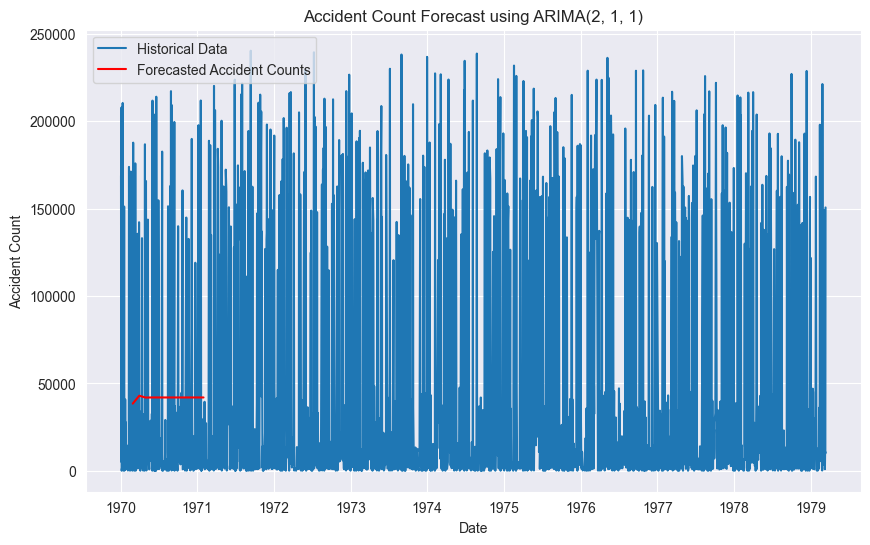

                              Forecasted_Accident_Count
1970-02-28 00:00:00.000003358                       NaN
1970-03-31 00:00:00.000003358                       NaN
1970-04-30 00:00:00.000003358                       NaN
1970-05-31 00:00:00.000003358                       NaN
1970-06-30 00:00:00.000003358                       NaN
1970-07-31 00:00:00.000003358                       NaN
1970-08-31 00:00:00.000003358                       NaN
1970-09-30 00:00:00.000003358                       NaN
1970-10-31 00:00:00.000003358                       NaN
1970-11-30 00:00:00.000003358                       NaN
1970-12-31 00:00:00.000003358                       NaN
1971-01-31 00:00:00.000003358                       NaN
